<a target="_blank" href="https://colab.research.google.com/github/lamm-mit/MechAgents/blob/main/0_colab_notebook_for_TwoAgentTeam_Elasticity/1_TwoAgen_OneStep_LE_to_HE.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# A Two-agent team try to solve linear and hyper-elasticity problems
Reference:
Ni, Bo, and Markus J. Buehler. "MechAgents: Large language model multi-agent collaborations can solve mechanics problems, generate new data, and integrate knowledge." Extreme Mechanics Letters (2024)

# 0. Prepare the packages

In [1]:
#@title #### prepare fenics for colab

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2023-11-06 00:39:36--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-11-06 00:39:36 (45.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/af0ba58/releases/pybind11-install.s

In [2]:
#@title #### prepare autogen

try:
    import chromadb
except ImportError:
    !pip install chromadb==0.4.15
    import chromadb

try:
    import tiktoken
except ImportError:
    !pip install tiktoken==0.5.1
    import tiktoken

try:
    import pypdf
except ImportError:
    !pip install pypdf==3.17.0
    import pypdf

# add autogen
#
try:
    import autogen
except ImportError:
    !pip install pyautogen==0.1.14
    import autogen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 9.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.9/103.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/5

# 1. Working part

## 1.1 Set the API endpoint

In [3]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    file_location=".",
    filter_dict={
        "model": ["gpt-3.5-turbo", "gpt-35-turbo", "gpt-35-turbo-0613", "gpt-4", "gpt4", "gpt-4-32k"],
    },
)

print("LLM models: ", [config_list[i]["model"] for i in range(len(config_list))])

LLM models:  []


In [4]:
# here, we set it locally
config_list_gpt = [
    {
        "model": "gpt-4",
        "api_key": "Your openAI API key"
    }
]


##1.2 Construct agents

In [5]:
# gpt4_config = {
#     "seed": 42,  # change the seed for different trials
#     "temperature": 0,
#     "config_list": config_list_gpt,
#     "request_timeout": 240,
# }

gpt4_config = {
    "seed": 42,  # change the seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt,
    "request_timeout": 600,
    "retry_wait_time": 120,
}

In [10]:
# create a UserProxyAgent instance named "user_proxy"
# 1. run code written by assistantAgent
# 2. provide feedback if needed, but keep quite during one round
#
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "Mechanics",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)


# create an AssistantAgent named "assistant"
# assistant = autogen.AssistantAgent(
#     name="assistant",
#     llm_config=gpt4_config,  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
#     system_message='''Assistant. You make plan, formulate the problem, write code using FENICS and review the result.'''
# )

assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config=gpt4_config,  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)


# # the assistant receives a message from the user_proxy, which contains the task description
# user_proxy.initiate_chat(
#     assistant,
#     message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
# )

In [7]:
# # create a UserProxyAgent instance named "user_proxy"
# # 1. run code written by assistantAgent
# # 2. provide feedback if needed, but keep quite during one round
# #
# user_proxy = autogen.UserProxyAgent(
#     name="user_proxy",
#     human_input_mode="NEVER",
#     max_consecutive_auto_reply=10,
#     is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
# )


# # create an AssistantAgent named "assistant"
# # assistant = autogen.AssistantAgent(
# #     name="assistant",
# #     llm_config=gpt4_config,  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
# #     system_message='''Assistant. You make plan, formulate the problem, write code using FENICS and review the result.'''
# # )

# assistant = autogen.AssistantAgent(
#     name="assistant",
#     llm_config=gpt4_config,  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
#     code_execution_config={
#         "work_dir": "Mechanics",
#         "use_docker": False,  # set to True or image name like "python:3" to use docker
#     },
# )


# # # the assistant receives a message from the user_proxy, which contains the task description
# # user_proxy.initiate_chat(
# #     assistant,
# #     message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
# # )

In [11]:
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""A 2D plate occupies 1m-by-1m domain.
    It is assumed as linear elastic and has Young's modulus of 1GPa and Poisson ration of 0.3.
    It has zero displacement on the left edge and 0.5m displacement along x direction on the right edge.
    The top and bottom edges are free to move.
    Solve for the displacement using FENICS with a fine mesh of 100by100 elements
    and store the displacement result in a PNG file named 1.png.""",
)

user_proxy (to assistant):

A 2D plate occupies 1m-by-1m domain.
    It is assumed as linear elastic and has Young's modulus of 1GPa and Poisson ration of 0.3.
    It has zero displacement on the left edge and 0.5m displacement along x direction on the right edge.
    The top and bottom edges are free to move.
    Solve for the displacement using FENICS with a fine mesh of 100by100 elements
    and store the displacement result in a PNG file named 1.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To solve this problem, we will use the FEniCS library in Python. FEniCS is a popular open-source (LGPLv3) computing platform for solving partial differential equations (PDEs). It allows users to quickly translate scientific models into efficient finite element code.

Here is the Python code to solve the problem:

```python
# filename: fenics_script.py

from fenics import *
import matplotlib.pyplot as plt

# Create mesh and defi

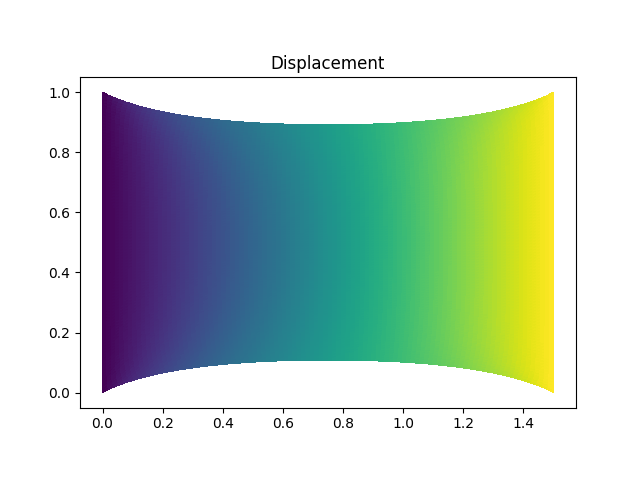

In [12]:
# show the result
from IPython.display import Image
Image('./Mechanics/1.png')

In [13]:
user_proxy.send(
    recipient=assistant,
    message="""Let's change the problem from linear elasticity into hyperelasticity.
    Please use a compressible Neo-hookean model with Young's modulus of 1GPa and Poisson ration of 0.3,
    please consider finite deformation, resolve the nonlinear problem and save result into another png file named 2.png.""",
)

user_proxy (to assistant):

Let's change the problem from linear elasticity into hyperelasticity.
    Please use a compressible Neo-hookean model with Young's modulus of 1GPa and Poisson ration of 0.3,
    please consider finite deformation, resolve the nonlinear problem and save result into another png file named 2.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To solve this problem, we will still use the FEniCS library in Python. The Neo-Hookean model is a hyperelastic model, suitable for representing the nonlinear elastic behavior of rubber-like materials. 

Here is the Python code to solve the problem:

```python
# filename: fenics_script.py

from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(100, 100)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0]

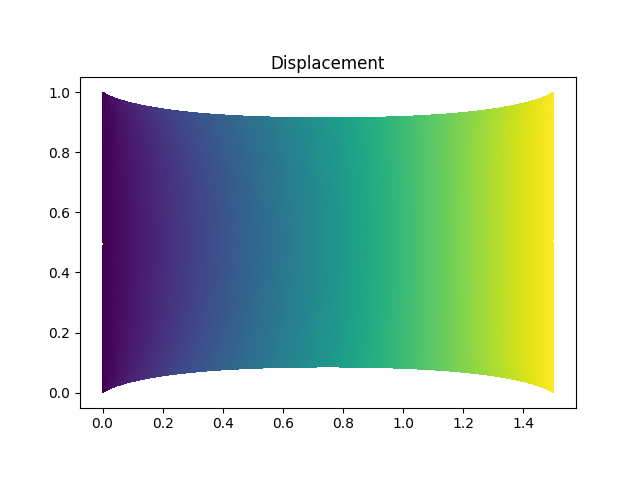

In [14]:
Image('./Mechanics/2.png')

In [15]:
# list the two images
from IPython.display import Image
from IPython.display import display

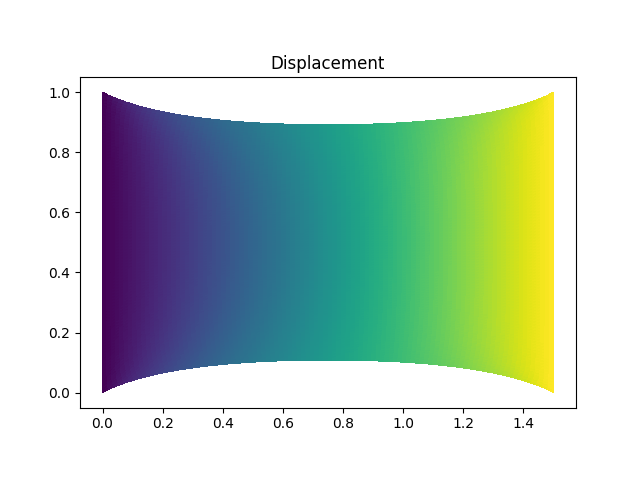

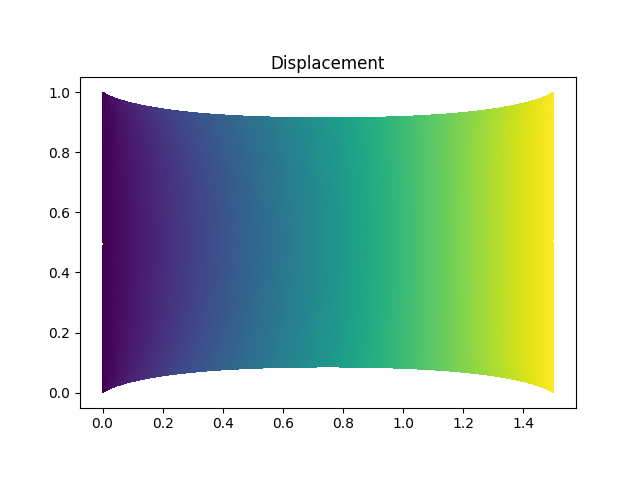

In [16]:
x = Image(filename='Mechanics/1.png')
y = Image(filename='Mechanics/2.png')
display(x, y)

In [18]:
!ls ./Mechanics

1.png  2.png  fenics_script.py	solution000000.vtu  solution.pvd


In [19]:


!zip -r /content/OneChat_Mechanics_file_OneStep_1.zip /content/Mechanics



  adding: content/Mechanics/ (stored 0%)
  adding: content/Mechanics/solution000000.vtu (deflated 74%)
  adding: content/Mechanics/fenics_script.py (deflated 48%)
  adding: content/Mechanics/1.png (deflated 3%)
  adding: content/Mechanics/solution.pvd (deflated 28%)
  adding: content/Mechanics/2.png (deflated 4%)


In [20]:
from google.colab import files

files.download("/content/OneChat_Mechanics_file_OneStep_1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wroking code ends here